In [1]:
import numpy as np
from scipy import integrate
from scipy import optimize

# some constants
G = 6.67428e-11   
solarmass = 1.98892e30 # mass of sun
h = 0.6774            # hubble constant 
c = 2.99792458e8            #speed of light
pc2m = 3.086e16      # 1 pc = 3.086e16 m 
year = 3.154e7 # 1 year in seconds
pi = np.pi
loge = np.log
log10 = np.log10
au = 1.496e11

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter 
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
class PBHbinary(object):
    """ 
    A group of PBH
    """
    def __init__(self, mass1,mass2,number=1e5,vrel=20):
        '''
        mass1: M_sun
        mass2: M_sun
        number: of samples
        vrel: m/s
        '''
        self.mass1 = mass1
        self.mass2 = mass2
        self.num = int(number)
        self.vrel = vrel
        self.eta = mass1*mass2/(mass1+mass2)**2
        self.mtotal = (mass1+mass2)*solarmass #unit: kg
        self.bmin = np.sqrt(12)*(3/340/pi/self.eta)**(1/7)*(self.vrel/c)**(2/7)
        self.random_b_sq = 1 - np.random.uniform(0,1-self.bmin**2,self.num)
        self.ini_ef = -1/2*self.mtotal*self.eta*self.vrel**2*( (1/self.random_b_sq)**(7/2)-1 )
    
    def ini_ecc(self):
        return np.sqrt( 1 - (340*pi*self.eta/3)**(2/7) * (self.vrel/c)**(10/7) * self.random_b_sq\
                       * ( (1/self.random_b_sq)**(7/2) - 1 )    )

    def ini_a(self):
        '''
        Initial semimajor axis length
        '''
        return G * self.mtotal / self.vrel**2 / ( (1/self.random_b_sq)**(7/2) - 1 ) /au
    
    def ini_rp(self):
        '''
        Initial semimajor axis length
        '''
        return self.ini_a()*au*( 1-self.ini_ecc() ) /1000 #unit: km
    
    def freqgw_to_a(self,f=10):
        '''
        m1:m_sun
        m2:m_sun
        f: GW frquency
        Derive the semimajor distance from a specific GW frequency according Kepler 3rd law
        '''
        return np.cbrt(G*self.mtotal/pi**2/f**2)
    
    def __Fe(self,e):
        return 1/(1+e)*(1+121/304*e**2)**(870/2299)
    
    def final_ecc(self,f=10):
        finalecc = []
        rp0 = self.ini_rp() * 1000
        e0 = self.ini_ecc()
        afinal = self.freqgw_to_a(f)
        for i in range(self.num):
            def CacheODEfunction(e):
                const = rp0[i]/e0[i]**(12/19) / self.__Fe(e0[i]) / afinal
                return (1-e) / e**(12/19) / self.__Fe(e) - const
            sol = optimize.root_scalar(CacheODEfunction, bracket=[1e-7, 1], method='brentq')
            finalecc.append(sol.root)
        finalecc = np.array(finalecc)
        return finalecc

In [115]:
#index name
bins = np.linspace(0,1,1001)
filename = {'m0p01':'PBHmass0p01vdist.txt','m0p1':'PBHmass0p1vdist.txt','m1':'PBHmass1vdist.txt','m5':'PBHmass0p5vdist.txt'}
PBHmass = {'m0p01':0.01,'m0p1':0.1,'m1':1,'m0p5':0.5}
ecc_result = {'m0p01': np.zeros(len(bins)-1),'m0p1':np.zeros(len(bins)-1),'m1':np.zeros(len(bins)-1),'m0p5':np.zeros(len(bins)-1)}
outputfile = {'m0p01':'fig3-PBHmass0p01Ecc.txt','m0p1':'fig3-PBHmass0p1Ecc.txt','m1':'fig3-PBHmass1Ecc.txt','m0p5':'PBHmass0p5Ecc.txt'}

for index in ['m0p01','m0p1','m1']:#'m0p01',
    vrel = np.loadtxt(filename[index])
    v_ind = 1
    eventnum = np.sum(vrel[:100,1])
    while(v_ind < 100):
        print(v_ind)
        '''
        vrel[v_ind,0]: the value to relative velocity, which controls the PBH eccentricity distribution at 10Hz
        vrel[v_ind,1]: the fraction of that velocity in the total events
        
        We simulate 5e5 sources to get the ecc distribution. (can change to a smaller number, but the fluctuation is higher)
        '''

        PBH = PBHbinary(mass1=PBHmass[index],mass2=PBHmass[index],vrel=vrel[v_ind,0],number=5e5)
        cache = np.histogram(PBH.final_ecc(),bins=bins,density=True)[0]
        ecc_result[index] += np.histogram(PBH.final_ecc(),bins=bins,density=True)[0] * vrel[v_ind,1]/eventnum 
        v_ind += 1
        #if v_ind == 20:
        #    plt.hist(PBH.final_ecc(),bins=bins, density=True,\
        # histtype='step',label='m='+str(PBHmass[index]))
    np.savetxt(outputfile[index],np.transpose(np.vstack((bins[:-1],ecc_result[index]))),fmt='%f',comments='bins  eccdistribution')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Plotting figures

In [3]:
a = np.loadtxt('fig3-PBHmass0p01Ecc.txt')
b = np.loadtxt('fig3-PBHmass0p1Ecc.txt')
c = np.loadtxt('fig3-PBHmass1Ecc.txt')

cumsuma = np.cumsum(a[:,1])
cumsumb = np.cumsum(b[:,1])
cumsumc = np.cumsum(c[:,1])

In [18]:
c[100,0]

0.1

In [26]:
1-cumsumc[99]/1000,1-cumsumb[99]/1000,1-cumsuma[99]/1000

(0.028192742999999854, 0.09162567899999952, 0.286616651)

### For 1/0.1/0.01 solar mass PBH binaries, there are 3%/9%/29% sources with ecc >= 0.1

In [22]:
c[10,0]

0.01

In [24]:
cumsumc[9],cumsumb[9],cumsuma[9]

(877.0507309999999, 603.297053, 107.191459)

In [25]:
1-cumsumc[9]/1000,1-cumsumb[9]/1000,1-cumsuma[9]/1000

(0.12294926900000003, 0.396702947, 0.892808541)

### For 1/0.1/0.01 solar mass PBH binaries, there are 12%/40%/89% sources with ecc >= 0.01

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


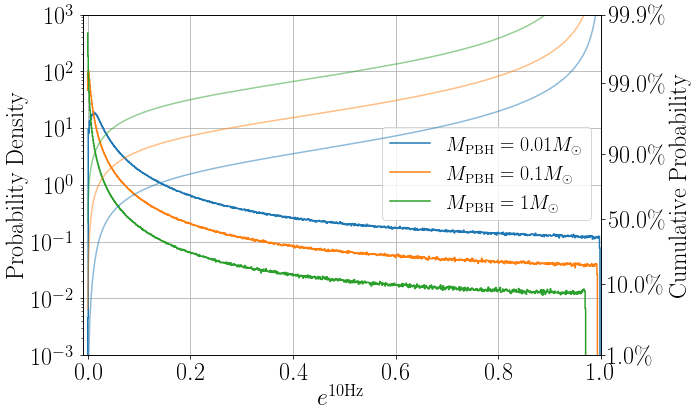

In [13]:
xlow = -0.01
xscale='linear'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(a[:,0],a[:,1],label=r'$M_\mathrm{PBH}=0.01M_\odot$')
ax.step(b[:,0],b[:,1],label=r'$M_\mathrm{PBH}=0.1M_\odot$')
ax.step(c[:,0],c[:,1],label=r'$M_\mathrm{PBH}=1M_\odot$')
ax.set_xlabel('$e^\mathrm{10Hz}$')
ax.set_ylabel('Probability Density')

ax.set_xlim(xlow,1)
ax.set_ylim(1e-3,1e3)
ax.set_yscale('log')
ax.set_xscale(xscale)
ax.legend(loc='upper right',bbox_to_anchor=(1, 0.7))


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(a[:,0],cumsuma/1000,alpha=0.5)
ax2.plot(b[:,0],cumsumb/1000,alpha=0.5)
ax2.plot(c[:,0],cumsumc/1000,alpha=0.5)

ax2.set_xlim(xlow,1)
ax2.set_xscale(xscale)
ax2.set_ylim(0.01,0.999)
ax2.set_yscale('logit')
ax2.set_ylabel('Cumulative Probability')
ax2.grid(b=False)
yticks = mtick.PercentFormatter(xmax=1,decimals=1) 
ax2.yaxis.set_major_formatter(yticks) 
ax2.set_yticks([0.01,0.1,0.5,0.9,0.99,0.999],minor='False')
fig.tight_layout()  # otherwise the right y-label is slightly clipped


fig.savefig('./../1-Manuscript/figures/0122-fig3-ecc.pdf',bbox_inches='tight')

# More numerical experiments

20
200
2000


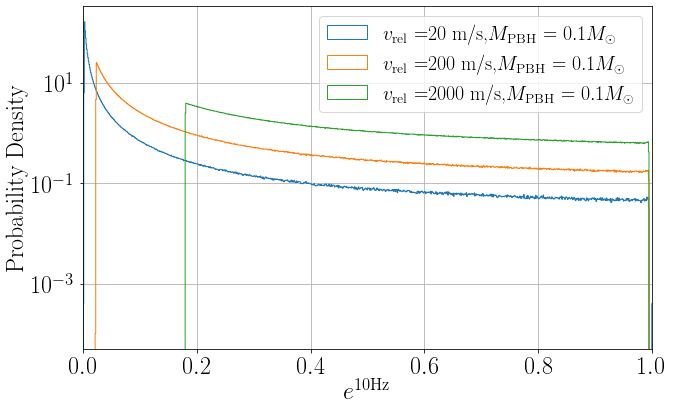

In [111]:
bins = np.linspace(0,1,1001)
for v in [20,200,2000]:
    print(v)
    PBH = PBHbinary(mass1=0.1,mass2=0.1,vrel=v,number=1e7)
    plt.hist(PBH.final_ecc(),bins=bins, density=True,\
         histtype='step',label=r'$v_\mathrm{rel}=$'+str(v)+' m/s,$M_\mathrm{PBH}=0.1M_\odot$')
plt.legend(loc='upper right')
plt.xlabel('$e^\mathrm{10Hz}$')
plt.ylabel('Probability Density')
plt.xlim(0,1)
plt.yscale('log')
plt.savefig('./../1-Manuscript/figures/0121-fig4-compecc.pdf',bbox_inches='tight')

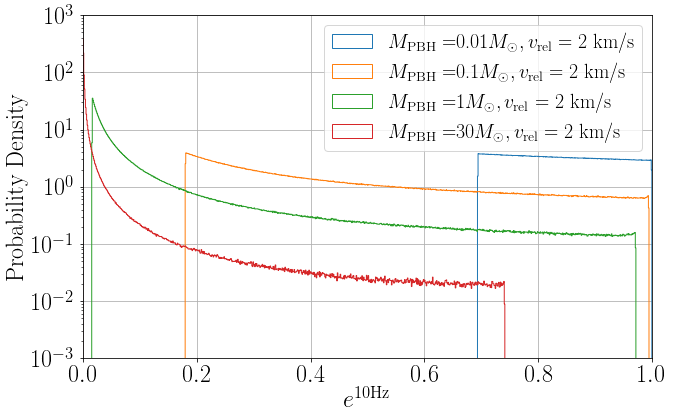

In [112]:
for m in [0.01,0.1,1,30]:
    PBH = PBHbinary(mass1=m,mass2=m,vrel=2000,number=1e7)
    plt.hist(PBH.final_ecc(),bins=bins, density=True,\
         histtype='step',label=r'$M_\mathrm{PBH}=$'+str(m)+'$M_\odot,v_\mathrm{rel}=2$ km/s')
plt.legend(loc='upper right')
plt.xlabel('$e^\mathrm{10Hz}$')
plt.ylabel('Probability Density')
plt.xlim(0,1)
plt.ylim(1e-3,1e3)
plt.yscale('log')
plt.savefig('./../1-Manuscript/figures/0121-fig5-compecc.pdf',bbox_inches='tight')